#  Forecasting the number of sold for Indian spices  
We will forecast the number of sold goods in the city of Bangalore (India)

## 1. Подготовительный этап

### 1.1 Импорт библиотек, данных

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [16]:
# sales data in India in various cities and states
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

df.date = pd.DatetimeIndex(df.date)

# sort and add date to the index
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

In [17]:
# we need only 'quantity' column, drop another
df_bang = df.loc[df.city == "BANGALORE"].copy()

# df_bang column's names convert to drop list
drop_list = list(df_bang.columns)
drop_list.remove('quantity')
print(drop_list)

# drop columns
ts = df_bang.drop(drop_list, axis=1)
ts_clean = pd.DataFrame(ts.copy())

ts.head()

['market', 'month', 'year', 'priceMin', 'priceMax', 'priceMod', 'state', 'city', 'date']


,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390


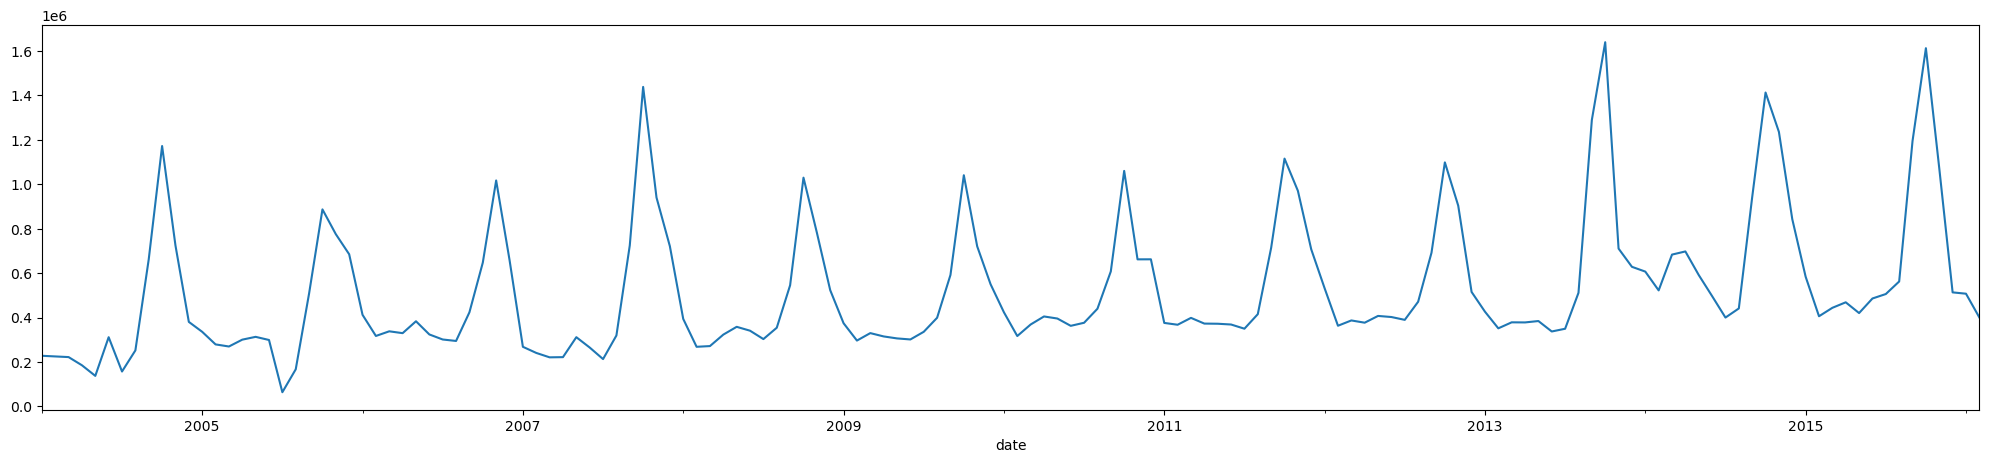

In [18]:
ts.quantity.plot(figsize=(25,5));

## 2. Data preprocessing

### 2.1 Create new TS features

In [19]:
# add lag features at first
for i in range(1, 8):
    ts[f"lag_{i}"] = ts.quantity.shift(i)

ts.dropna(inplace=True)
    
print(ts[1:12])

         quantity      lag_1      lag_2      lag_3      lag_4      lag_5  \
date                                                                       
2004-09    662382   251984.0   157022.0   311445.0   137390.0   185150.0   
2004-10   1171846   662382.0   251984.0   157022.0   311445.0   137390.0   
2004-11    724140  1171846.0   662382.0   251984.0   157022.0   311445.0   
2004-12    380379   724140.0  1171846.0   662382.0   251984.0   157022.0   
2005-01    335679   380379.0   724140.0  1171846.0   662382.0   251984.0   
2005-02    279047   335679.0   380379.0   724140.0  1171846.0   662382.0   
2005-03    269609   279047.0   335679.0   380379.0   724140.0  1171846.0   
2005-04    300428   269609.0   279047.0   335679.0   380379.0   724140.0   
2005-05    313052   300428.0   269609.0   279047.0   335679.0   380379.0   
2005-06    298906   313052.0   300428.0   269609.0   279047.0   335679.0   
2005-07     63824   298906.0   313052.0   300428.0   269609.0   279047.0   

           

### 2.2 Split train & test df

In [20]:
# split
split_index = int(0.85*len(ts))

train = ts[:split_index]
test = ts[split_index:]

print(f'Train shape is {train.shape} and test shape is {test.shape}')

Train shape is (118, 8) and test shape is (21, 8)


In [21]:
# stand out X y
y_train = train['quantity']
y_test = test['quantity']

X_train = train.drop('quantity', axis=1)
X_test = test.drop('quantity', axis=1)

### 2.3 Create agregating features

Previously I used pivot tables to create aggregate attributes like average for the day, but now I found a way to do it more laconic.

In [22]:
# func create the dictionary with key - feature name, value - aggregated feature
# above we use it for mean value
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [23]:
# check it on month mean
ts['month'] = ts.index.month
mean_dict = code_mean(ts,'month','quantity')

display(mean_dict)

{1: 436629.0833333333,
 2: 344012.0,
 3: 371731.36363636365,
 4: 380720.8181818182,
 5: 385653.45454545453,
 6: 362042.2727272727,
 7: 326113.2727272727,
 8: 385456.6666666667,
 9: 741183.9166666666,
 10: 1179204.8333333333,
 11: 876030.3333333334,
 12: 615578.75}

## 3.0 Baseline

CPU times: user 67.1 ms, sys: 0 ns, total: 67.1 ms
Wall time: 66.7 ms


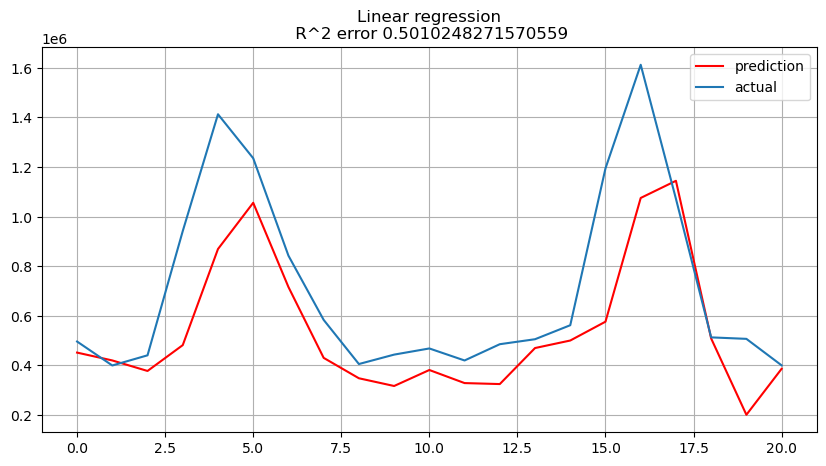

In [24]:
%%time

# declare the regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.grid(True)
plt.legend(loc='best')
plt.title(f'Linear regression\n R^2 error {r2_score(y_test,y_pred)}');

## 4. Model improvement

### 4.1 Add the average for the month

In [25]:
"""
In common case it will be:
ts['month_avg'] = list(map(code_mean(ts, 'month', 'quantity').get, ts.month))

1) split_index will prevent future data leaks;
2) get method method returns the value of the item with the specified key;
3) map applies code_mean func to ts.month;
"""

ts['month_avg'] = list(map(code_mean(ts.iloc[:split_index], 'month', 'quantity').get, ts.month))
ts.head()

,quantity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,month,month_avg
date,,,,,,,,,,
2004-08,251984,157022.0,311445.0,137390.0,185150.0,221952.0,225133.0,227832.0,8,362241.8
2004-09,662382,251984.0,157022.0,311445.0,137390.0,185150.0,221952.0,225133.0,9,675778.1
2004-10,1171846,662382.0,251984.0,157022.0,311445.0,137390.0,185150.0,221952.0,10,1112561.2
2004-11,724140,1171846.0,662382.0,251984.0,157022.0,311445.0,137390.0,185150.0,11,820510.3
2004-12,380379,724140.0,1171846.0,662382.0,251984.0,157022.0,311445.0,137390.0,12,603110.6


### 4.2 Create special function for data preprocessing

In [26]:
def preprocess_data(data, lag_start=1, lag_end=8, split_index=split_index):
    data = pd.DataFrame(data.copy())

    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data['quantity'].shift(i)

    data = data.dropna()

    data['month'] = data.index.month

    data['month_avg'] = list(map(code_mean(data.iloc[:split_index], 'month', 'quantity').get, data.month))

    # name of the month we don't need any more, drop it
    data.drop(['month'], axis=1, inplace=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:split_index].drop(['quantity'], axis=1)
    y_train = data.iloc[:split_index]['quantity']
    X_test = data.iloc[split_index:].drop(['quantity'], axis=1)
    y_test = data.iloc[split_index:]['quantity']

    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = preprocess_data(ts_clean)

X_train.shape, X_test.shape

((118, 8), (21, 8))

### 4.3 Check the R^2 result

CPU times: user 15.2 ms, sys: 1.88 ms, total: 17.1 ms
Wall time: 16.6 ms


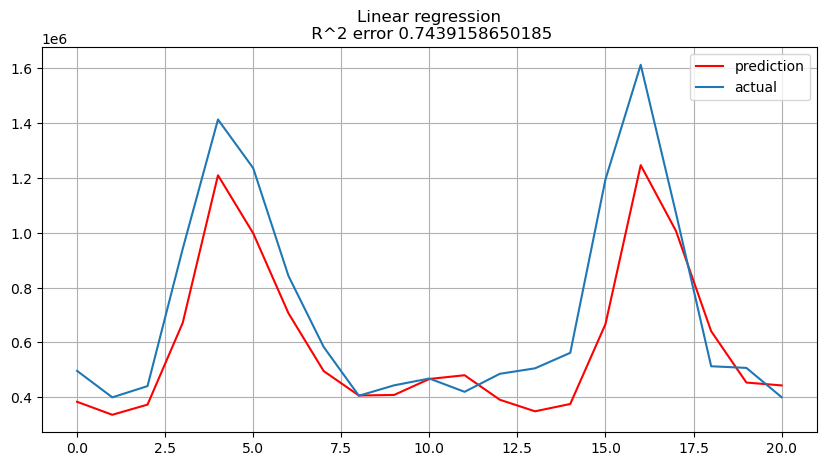

In [28]:
%%time

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.grid(True)
plt.legend(loc='best')
plt.title(f'Linear regression\n R^2 error {r2_score(y_test,y_pred)}');